In [2]:
import pandas as pd
# carregando dados de treino
df_x = pd.read_csv("./dataset/Training/TrainingAccZAxis.txt", header=None)
df_x.columns =[ "AccZAxis"]
df_y = pd.read_csv("./dataset/Training/TrainingStepsOrNot.txt", header=None)
df_y.columns =[ "Step"]

# carregando dados de teste
df_x_test = pd.read_csv("./dataset/Testing/TestingAccZAxis.txt", header=None)
df_x_test.columns =[ "AccZAxis"]
df_y_test = pd.read_csv("./dataset/Testing/TestingStepsOrNot.txt", header=None)
df_y_test.columns =[ "Step"]



<AxesSubplot:title={'center':'raw data z axis'}>

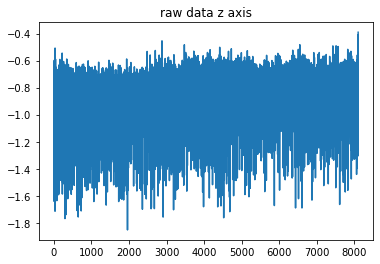

In [5]:
df_x["AccZAxis"].plot(title="raw data z axis")

<AxesSubplot:title={'center':'raw data z axis window'}>

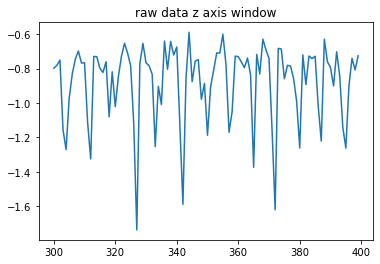

In [8]:
df_x["AccZAxis"][300:400].plot(title="raw data z axis window of 10 seconds")

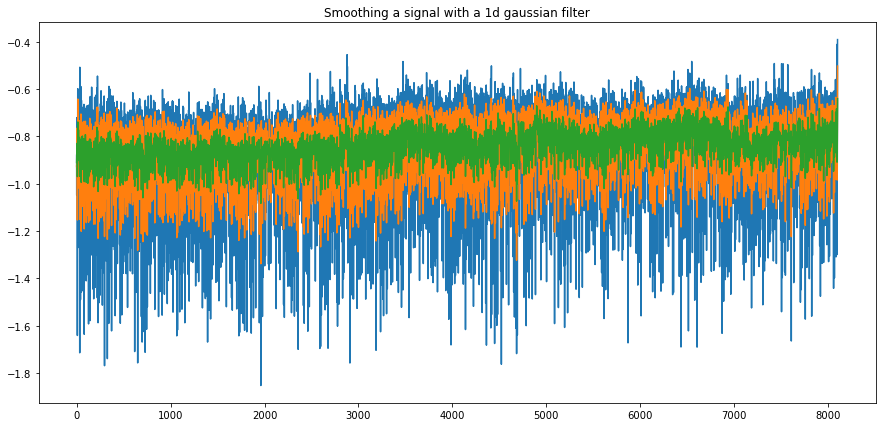

In [19]:
# code for smoothing a signal with a 1d gaussian filter
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt

plt.figure(figsize=(15,7))
plt.plot(df_x["AccZAxis"], label="raw data")
plt.plot(gaussian_filter1d(df_x["AccZAxis"], sigma=1), label="smoothed data $\sigma=1$")
plt.plot(gaussian_filter1d(df_x["AccZAxis"], sigma=2), label="smoothed data $\sigma=2$")
plt.title("Smoothing a signal with a 1d gaussian filter")
plt.show()

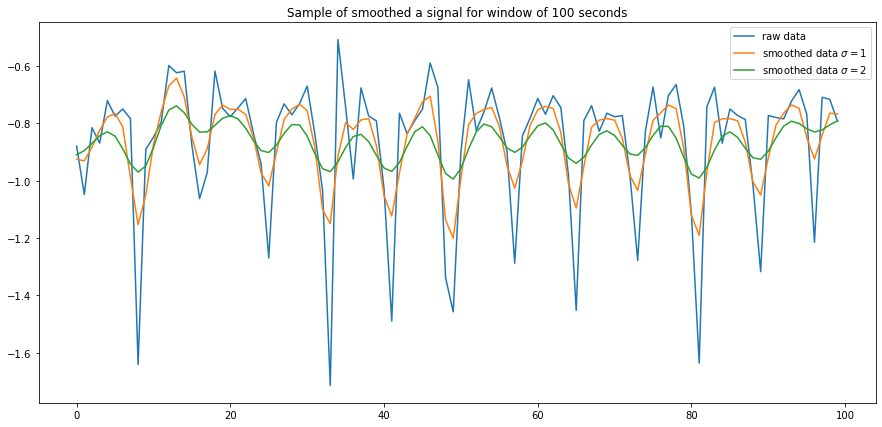

In [23]:

start = 0
end = 100
plt.figure(figsize=(15,7))
plt.plot(df_x["AccZAxis"][start:end], label="raw data")
plt.plot(gaussian_filter1d(df_x["AccZAxis"][start:end], sigma=1), label="smoothed data $\sigma=1$")
plt.plot(gaussian_filter1d(df_x["AccZAxis"][start:end], sigma=2), label="smoothed data $\sigma=2$")
plt.title("Sample of smoothed a signal for window of 100 seconds")
plt.legend()
plt.show()

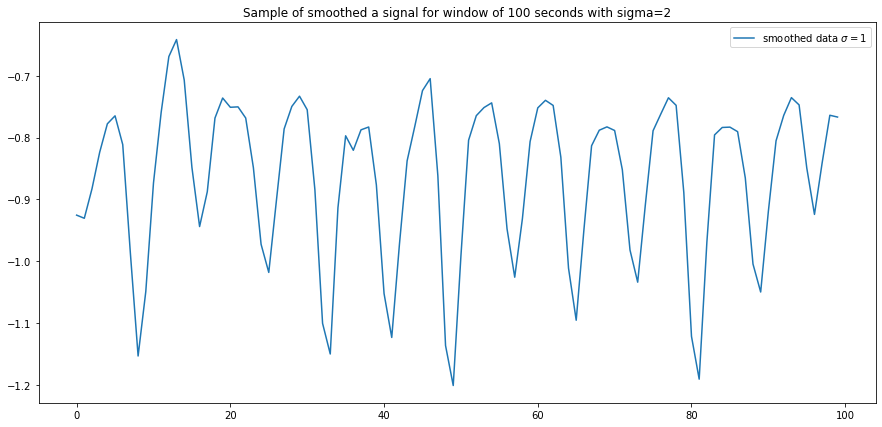

In [24]:
start = 0
end = 100
plt.figure(figsize=(15,7))
plt.plot(gaussian_filter1d(df_x["AccZAxis"][start:end], sigma=1), label="smoothed data $\sigma=1$")
plt.title("Sample of smoothed a signal for window of 100 seconds with sigma=2")
plt.legend()
plt.show()

[People around the age of 21-40 years have a cadence of about 48-60 steps per minute](https://www.mdpi.com/2504-3900/31/1/60/pdf)

That means that 1 step would occur in a range of around:
$$
stepMin = 48/60 = 0.8 \space step/s  \newline
stepMax = 60/60 = 1 \space step/s
$$

Given this information and the profile of the smoothed signal collected, I would at 10hz, we could use window sizes for step detection of around 1 second which would be about 10 samples per segmented signal, inspiration from the preprocessing protocol seen [here](https://www.mdpi.com/2504-3900/31/1/60/pdf)

(The window size used in `FAA_Proj1_Step_ANN.ipynb` was 3 which at 10Hz would mean 
0.33s which is much lower with respect to the average cadence of a person.)  

Following the gait classification paragraph in [here](https://www.mdpi.com/2504-3900/31/1/60/pdf), we will segment the signals and after that, we will 
have two versions of the dataset, one with only the segmented signals raw,
and another with feature vectors extracted from the segmented signals where we 
will extract:
- height of the peak of the accelerometer data
- mean of the acceleration
- standard deviation of the acceleration

Besides that we will also use the difference dataset from `TrainingDiffs.txt`
and apply similar segmentation and preprocessing.

For the models we will some of the architectures described [here](https://run.unl.pt/bitstream/10362/106544/1/Rodrigues_2020.pdf)

In [62]:
import numpy as np
# smoothing the signal
smoothed_signal = gaussian_filter1d(df_x["AccZAxis"], sigma=1)

# segmenting the signal with a window size of 10 seconds
window_size = 10
x_train = np.empty((int(len(df_x)/window_size - 1), window_size))
y_train = np.empty((int(len(df_x)/window_size - 1),))
for i in range(0, len(smoothed_signal) - window_size, window_size):
    x_train[int(i/window_size)] = smoothed_signal[i:i+window_size]
    y_train[int(i/window_size)] = df_y["Step"][i+window_size]

print(x_train.shape)
print(y_train.shape)

(809, 10)
(809,)


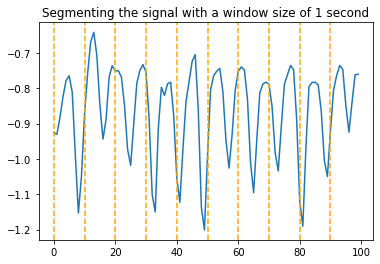

In [61]:
# Visualizing the segment windows with vertical lines in the original 
# smoothed signal
fig, ax = plt.subplots()
ax.plot(smoothed_signal[:100], label="smoothed data")
for i in range(0,100,window_size):
    ax.axvline(x=i, color='orange', linestyle='--')
plt.title("Segmenting the signal with a window size of 1 second")
plt.show()

In [71]:
from models import *

lstm = lstm_model(n_timesteps=x_train.shape[1], n_features=1, n_outputs=1)
epochs = 1000
batch_size = 64
# preprocessing the data for fitting a RNN model
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
history = lstm.fit(x_train, y_train, epochs=epochs,batch_size=batch_size, verbose=0)

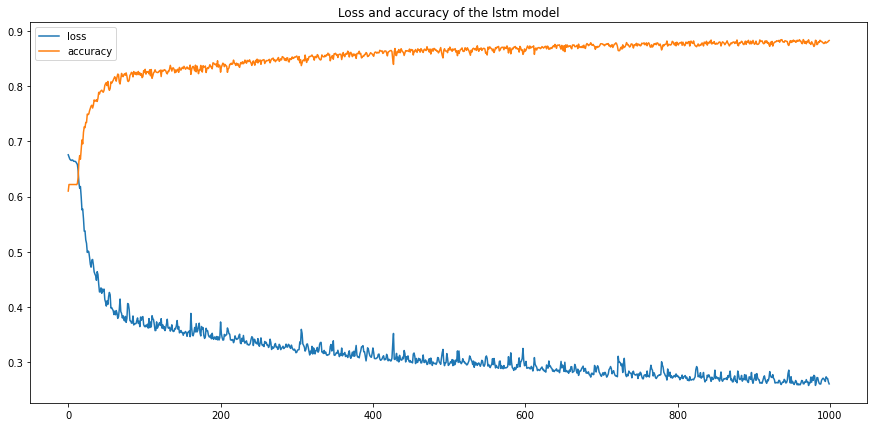

In [77]:
# plot loss and accuracy
def plotPerformance(history):    
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.title("Loss and accuracy of the lstm model")
    plt.legend()
    plt.show()


In [103]:
net = basic_neural_net(input_shape=(x_train.shape[1],))
epochs = 250
batch_size = 32
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
history = net.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
print("Loss: ",history.history["loss"][-1])
print("Accuracy: ",history.history["accuracy"][-1])


0.14619283378124237
0.9381952881813049


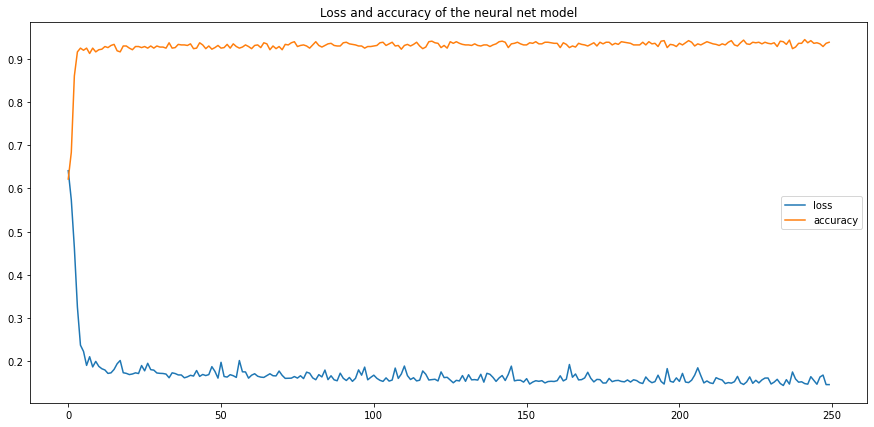

In [104]:
def plotPerformance(history, model_name):    
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.title(f"Loss and accuracy of the {model_name} model")
    plt.legend()
    plt.show()

plotPerformance(history, "neural net")

Loss:  0.10995597392320633
Accuracy:  0.9530284404754639


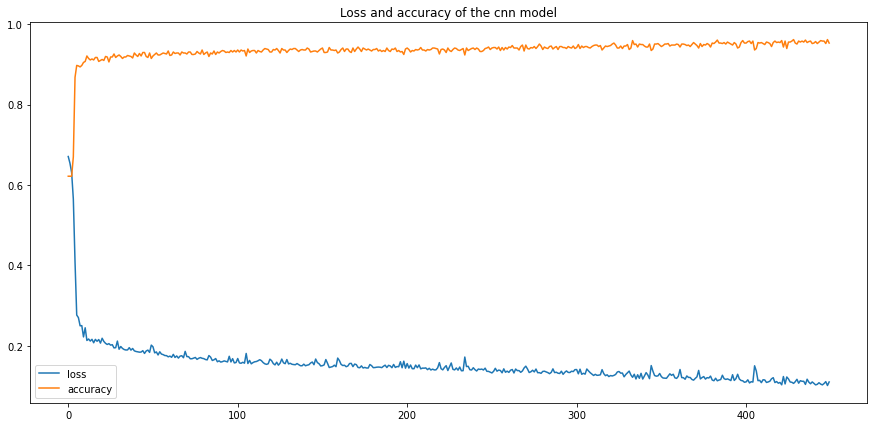

In [113]:
cnn = cnnModel((x_train.shape[1], 1))
epochs = 450
batch_size = 32
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1],1)
history = cnn.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
print("Loss: ",history.history["loss"][-1])
print("Accuracy: ",history.history["accuracy"][-1])
plotPerformance(history, "cnn")


In [ ]:
# Now I should apply the preprocessing and fit the model on the test data
# also restructure the code and modularize it